 Consider using :
- Distant GPU instance if you want to perform  large model inferences (ex: model evaluation on full test dataset).
- Local CPU if you want to view the results only (test_results.json) or run small inferences.

# Prepare the notebook

## Prepare on distant Colab instance (GPU)

Use this section to mount the Google Drive folder, extract the zipped dataset, import the necessary libraries, and define the file paths on a Google Colab instance.

Running the notebook on GPU, allows you the accelerate the model inference.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install ultralytics
!pip install pyquaternion

In [ ]:
import os
import sys
import json
import zipfile
import numpy as np
from pycocotools.coco import COCO
import torch
import torchvision
from ultralytics import YOLO



__file__ = "/content/drive/MyDrive/aspera_pose_estimation/keypoints_regression/yournotebook.ipynb" # Make sure to set this to the path of the notebook on your drive/system
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

from utils.transformations import *
from utils.visualizations import *
from utils.metrics import *


### CONFIGURATION ###
RELATIVE_ROOT = '..' # Relative path to the root of the project
ROOT_PATH = os.path.abspath(os.path.join(os.path.dirname(__file__), RELATIVE_ROOT))

# DRIVE ZIP
ZIP_FILE = 'data/spv2-COCO-s.zip' # Path to the dataset zip file in the drive
ZIP_PATH = os.path.join(ROOT_PATH, ZIP_FILE)

# Dataset
DATASET = '' # Name of the dataset
DATA_TYPE = 'synthetic' # Type of the dataset: 'synthetic' or 'lightbox' or 'sunlamp'
IMAGES_FOLDER = f'../../../{DATASET}/{DATA_TYPE}/images/test' # Path to the images local folder when unzipped
ANNOTATIONS_FILE= f'../../../{DATASET}/{DATA_TYPE}/annotations/test.json' # Path to the annotations local file when unzipped
IMAGES_PATH = os.path.join(ROOT_PATH, IMAGES_FOLDER)
ANNOTATIONS_PATH = os.path.join(ROOT_PATH, ANNOTATIONS_FILE)

# Model
WEIGHTS_TYPE = 'sy2li'
WEIGHTS = f'keypoints_regression/results/{WEIGHTS_TYPE}_train/weights/best.pt'
WEIGHTS_PATH = os.path.join(ROOT_PATH, WEIGHTS)
MATCHING_MATRIX = None

# Dataset
IMAGES_FOLDER = f'../../../{DATASET}/{DATA_TYPE}/images/test' # Path to the images local folder when unzipped
ANNOTATIONS_FILE= f'../../../{DATASET}/{DATA_TYPE}/annotations/test.json' # Path to the annotations local file when unzipped
IMAGES_PATH = os.path.join(ROOT_PATH, IMAGES_FOLDER)
ANNOTATIONS_PATH = os.path.join(ROOT_PATH, ANNOTATIONS_FILE)

# Results
SAVE = True# Save the results in a json file
RESULTS_FILE = f'keypoints_regression/results/yolov8/test/{DATA_TYPE}_keypoints_regression.json'
RESULTS_PATH = os.path.join(ROOT_PATH, RESULTS_FILE)
# Output
OUTPUT_DIR = 'keypoints_regression/results/yolov8/test/'
OUTPUT_PATH = os.path.join(ROOT_PATH, OUTPUT_DIR)

In [ ]:
# Extract the dataset on distant instance
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
  zip_ref.extractall('')

## Prepare on local instance (CPU)

Use this section to import the necessary libraries, and define the file paths on a local instance.

Running the notebook on CPU, allows you to view the results of the evaluation or debug.

In [2]:
import os
import sys
import json
import zipfile
import numpy as np
from pycocotools.coco import COCO
import torch
from torchvision.transforms import ToTensor, Resize
from ultralytics import YOLO



__file__ = "" # Make sure to set this to the path of the notebook on your drive/system
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

from utils.transformations import *
from utils.visualizations import *
from utils.metrics import *


### CONFIGURATION ###
RELATIVE_ROOT = '..' # Relative path to the root of the project
ROOT_PATH = os.path.abspath(os.path.join(os.path.dirname(__file__), RELATIVE_ROOT))

# Dataset
DATASET = 'spv2-COCO-s' # Name of the dataset
DATA_TYPE = 'lightbox' # Type of the dataset: 'synthetic' or 'lightbox' or 'sunlamp'
IMAGES_FOLDER = f'data/{DATASET}/{DATA_TYPE}/images/test' 
ANNOTATIONS_FILE= f'data/{DATASET}/{DATA_TYPE}/annotations/test.json' 
IMAGES_PATH = os.path.join(ROOT_PATH, IMAGES_FOLDER)
ANNOTATIONS_PATH = os.path.join(ROOT_PATH, ANNOTATIONS_FILE)

# Model
WEIGHTS_TYPE = 'sy2li'
WEIGHTS = f'keypoints_regression/results/yolov8/{WEIGHTS_TYPE}_train/weights/best.pt'
WEIGHTS_PATH = os.path.join(ROOT_PATH, WEIGHTS)
MATCHING_MATRIX = None

# Results
SAVE = True # Save the results in a json file
RESULTS_FILE = f'keypoints_regression/results/yolov8/{WEIGHTS_TYPE}_test/{DATA_TYPE}_keypoints_regression.json'
RESULTS_PATH = os.path.join(ROOT_PATH, RESULTS_FILE)
# Output
OUTPUT_DIR = f'keypoints_regression/results/yolov8/{WEIGHTS_TYPE}_test/'
OUTPUT_PATH = os.path.join(ROOT_PATH, OUTPUT_DIR)

# Load elements

## Load  groundtruth annotations


In [3]:
# Load the COCO annotations using the pycocotools library
coco = COCO(ANNOTATIONS_PATH)
imgsz_gt = coco.imgs[list(coco.imgs.keys())[0]]['height'], coco.imgs[list(coco.imgs.keys())[0]]['width']
print('---------------------------------')
print(f'Image size from ground truth : {imgsz_gt}')

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
---------------------------------
Image size from ground truth : (400, 640)


## Load model

In [4]:
# Load model (if WARNING : smdebug... just ignore it and run again the cell)
model = YOLO(WEIGHTS_PATH)

# Run model


In [1]:
image_files = os.listdir(IMAGES_PATH)
outputs = []

images_path = [os.path.join(IMAGES_PATH, image_file) for image_file in image_files]
outputs= model.predict(images_path,stream=True)

print(f'Done. Number of images processed: {len(outputs)}')

NameError: name 'os' is not defined

# Generate & View results

### Generate PCK_matrix

This section aims to verify that the groundtruth keypoint indexes match with the predicted keypoint indexes. (Not the case for yolov8 model => matching matrix).

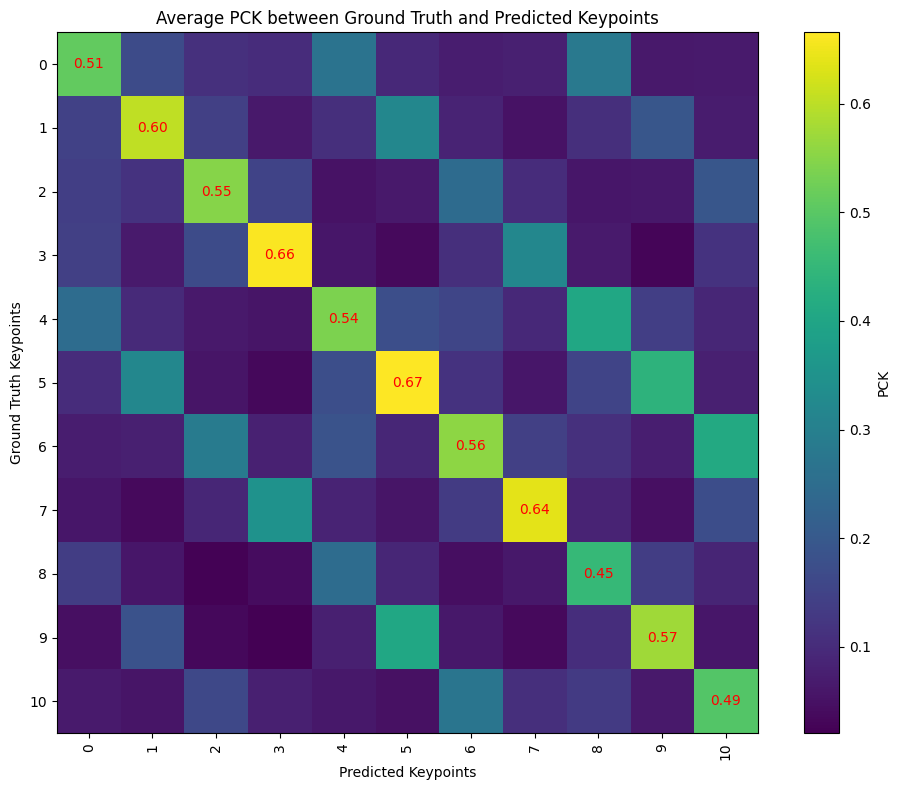

In [21]:
# Define the PCK threshold (e.g., 0.05 of the image diagonal)
pck_threshold = 0.05 * np.linalg.norm(imgsz_gt)

# Initialize an accumulator for the PCK matrices and a counter for the images
accumulated_pck_matrix = None
num_images = 0

# Evaluate the PCK matrix over all the images

for output,image_file in zip(outputs,image_files):
    # groundtruth keypoints, labels, and skeleton
    anns = loadImgAnns(image_file, coco)
    gt_keypoints = anns['keypoints']
    keypoints_labels = anns['keypoints_labels']
    skeleton = anns['skeleton']

    # Extract the predicted keypoints
    if output.keypoints.data.shape[0] == 1 :
        x=output.keypoints.data.detach().cpu().squeeze().flatten()
        p_keypoints = x.tolist()
    else:
        continue # don't consider multiple or no predictions

    # Extract (x, y) coordinates from the keypoints
    coordinates_gt = extractCoord(gt_keypoints)
    coordinates_pred = extractCoord(p_keypoints)
    # Calculate PCK matrix between GT and predicted keypoints
    pck_matrix = calculatePCKMat(coordinates_gt,coordinates_pred, pck_threshold)    #Accumulate the PCK matrices
    if accumulated_pck_matrix is None:
        accumulated_pck_matrix = pck_matrix
    else:
        accumulated_pck_matrix += pck_matrix

    num_images += 1

# Calculate the average PCK matrix
average_pck_matrix = accumulated_pck_matrix / num_images

# Plot the average PCK matrix with annotations
plotPCKMat(average_pck_matrix)


## Export predictions

In [22]:
# BENCHMARKING
mse = []
pck = []
results_json = []
for output, image_file in zip(outputs, image_files):

    # ground truth keypoints, labels, and skeleton
    anns = loadImgAnns(image_file, coco)
    gt_keypoints = anns['keypoints']
    keypoints_labels = anns['keypoints_labels']
    skeleton = anns['skeleton']

    n_sat = output.keypoints.data.shape[0] # number of satellites predicted
    x = output.keypoints.data.detach().cpu().squeeze().flatten() # predicted keypoints
    p_keypoints = x.tolist()

    gt_keypoints = extractCoord(gt_keypoints)
    p_keypoints = extractCoord(p_keypoints)

    results_json.append({
        'filename': image_file,
        'n_sat' : n_sat,
        'gt_keypoints': gt_keypoints,
        'skeleton': skeleton,
        'labels': keypoints_labels,
        'p_keypoints': p_keypoints,
    })

#Save results to JSON
if SAVE :
    os.makedirs(OUTPUT_PATH, exist_ok=True)
    with open(RESULTS_PATH, 'w') as f:
        json.dump(results_json, f)
print(f'SAVE was set to {SAVE}. (if True, the results are saved in {RESULTS_PATH})')

SAVE was set to True. (if True, the results are saved in /home/matthieu/aspera/aspera_pose_estimation/keypoints_regression/results/yolov8/sy2su_test/sunlamp_keypoints_regression.json)


## Metrics

PCK threshold: 37.73592452822642 px
 Skipped : 10.19 % of the images due to wrong number of keypoints.
------- Keypoints Regression Scores -------
Average PCK [u]: 0.5689805402265465
Standard deviation of PCK [u]: 0.35552373425886774
Average MSE [px²]: 5919.7890647690965
Standard deviation of MSE [px²]: 9187.630332059924
------------------------------------


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

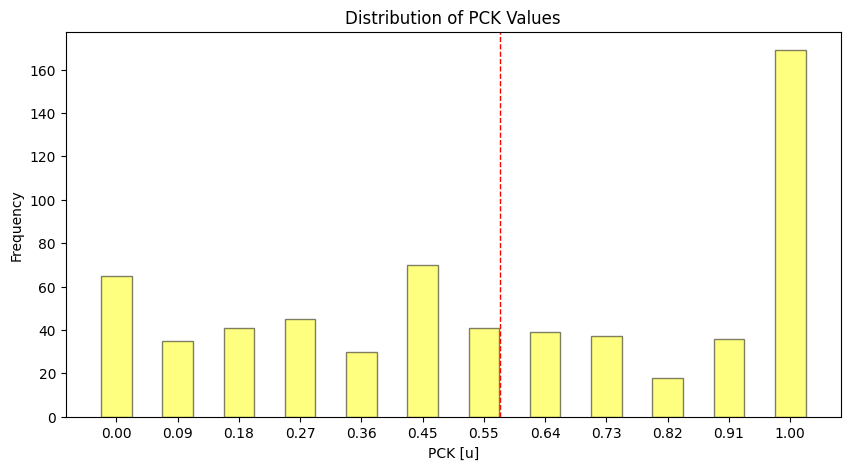

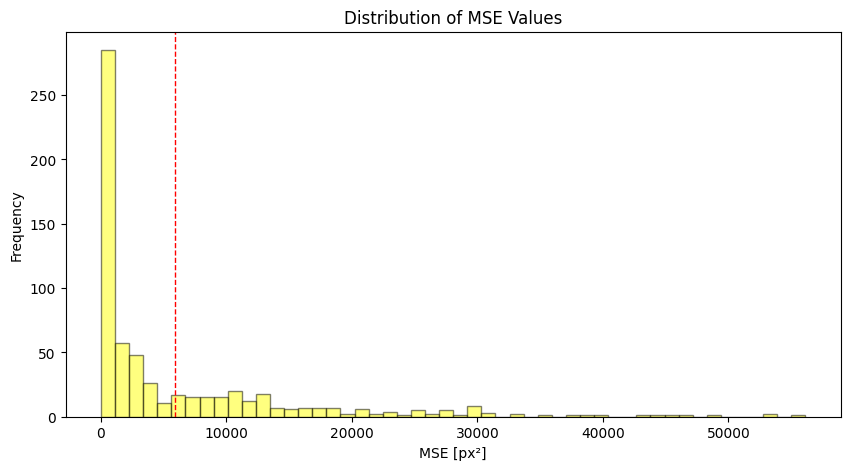

Evaluation results saved successfully.


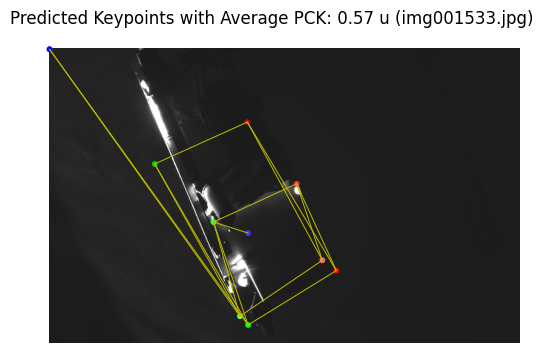

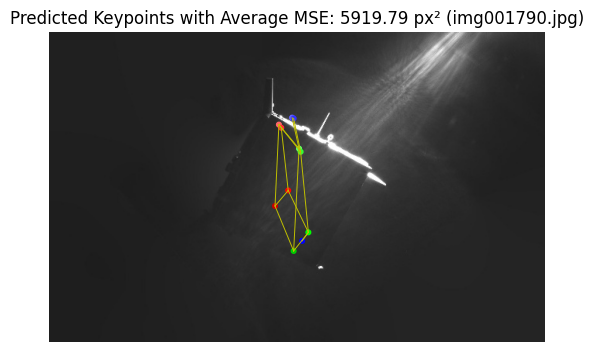

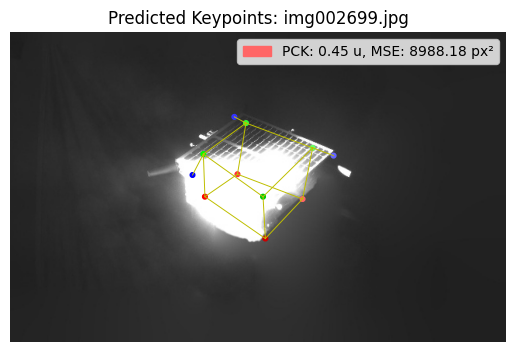

In [23]:
# threshold for PCK
pck_threshold = 0.05 * np.linalg.norm(imgsz_gt)
print(f'PCK threshold: {pck_threshold} px')

# Load json file
with open(RESULTS_PATH) as f:
    results_json = json.load(f)

keypointsMetrics = KeypointsMetrics(results_json,pck_threshold)
keypointsMetrics.save(img_dir=IMAGES_PATH ,save_dir=OUTPUT_PATH,data_type=DATA_TYPE)

